### Disclaimer

I do not own any of the images used in this project. Credit of the art goes to their respective owners:

**Fede:** https://fedecalandria.com

**Mi amigo invencible:** https://www.youtube.com/watch?v=rr7g3wrXnS4&ab_channel=miamigoinvencible

Special thanks to [Winston Herring](https://github.com/winston6) and [Alexis Jacq](https://alexis-jacq.github.io/) for their amazing tutorial:

[NEURAL TRANSFER USING PYTORCH](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

## Setup

### Environment

In [ ]:
!pip install fastai --upgrade

In [2]:
from fastai.data.all import *
from fastai.vision.all import *

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading images

In [4]:
style_url = "https://i.ytimg.com/vi/rr7g3wrXnS4/maxresdefault.jpg"
content_url = "https://avatars2.githubusercontent.com/u/18092974?s=400&v=4"

style_path = Path("./style.jpg")
content_path = Path("./content.jpg")

stlye_img = download_url(style_url, style_path)
content_img = download_url(content_url, content_path)

In [5]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
                             transforms.Resize((imsize, imsize)),
                             transforms.ToTensor()
])

def image_loader(fname):
  img = Image.open(fname)
  img = loader(img).unsqueeze(0)
  return img.to(device, torch.float)

style_img = image_loader(style_path)
content_img = image_loader(content_path)

print(style_img.size(), content_img.size())

assert style_img.size() == content_img.size(), \
  "images should be of the same size"

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


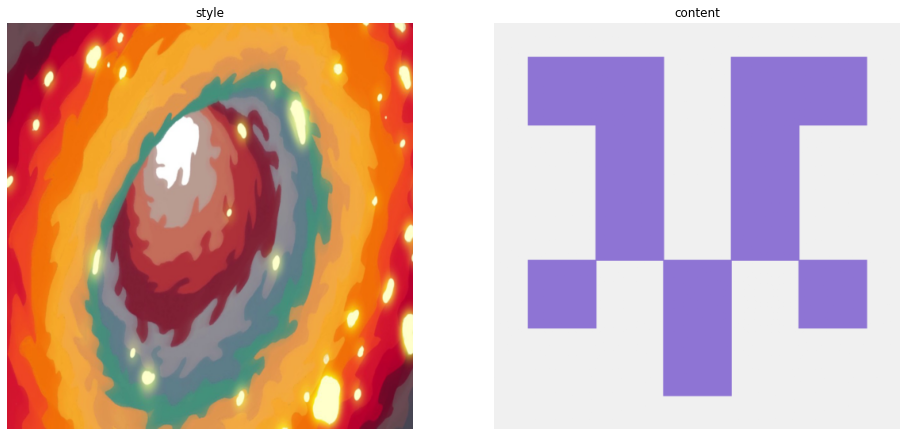

In [6]:
show_images(tuple(map(lambda img: img.cpu().clone().squeeze(0), (style_img, content_img))), 
            titles=("style", "content"), imsize=8)

## Loss Functions

### Content Loss

In [7]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

### Style Loss

In [8]:
def gram_matrix(input):
  a, b, c, d = input.size() # B x K x W x H (K is # of kernels)
  features = input.view(a * b, c * d)
  G = torch.mm(features, features.t())
  # divide by the total number of elements in the matrix to normalize
  return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

## Importing the Model

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [11]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [12]:
cnn_normalization_mean = torch.tensor(imagenet_stats[0]).to(device)
cnn_normalization_std = torch.tensor(imagenet_stats[1]).to(device)

In [13]:
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)
  
  def forward(self, img):
    return (img - self.mean) / self.std

In [14]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
  cnn = copy.deepcopy(cnn)

  normalization = Normalization(normalization_mean, normalization_std).to(device)
  
  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    
    model.add_module(name, layer)
    
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)
    
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
  # remove last layers after the last ContentLoss or StyleLoss
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break

  model = model[:(i + 1)]

  return model, style_losses, content_losses

## Input image

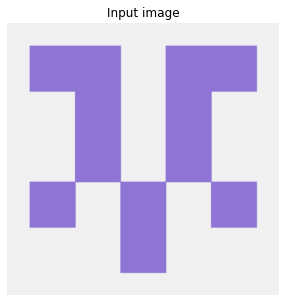

In [15]:
input_img = content_img.clone()
show_image(input_img.cpu().clone().squeeze(0), title='Input image')

## Gradient Descent

In [16]:
def get_input_optimizer(input_img):
  # the author of the paper suggests to use LBFGS
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

This feeds an updated input and computes new losses

In [17]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=100000, content_weight=1):
  model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                          normalization_mean, normalization_std,
                                          style_img, content_img)
  optimizer = get_input_optimizer(input_img)
  run = [0]
  while run[0] <= num_steps:
    def closure():
      input_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print("Style Loss: {:4f} Content Loss: {:4f}\n".format(
            style_score.item(), content_score.item()))
      
      return style_score + content_score
    
    optimizer.step(closure)
  
  input_img.data.clamp_(0, 1)
  return input_img

## Running the algorithm

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, 300)

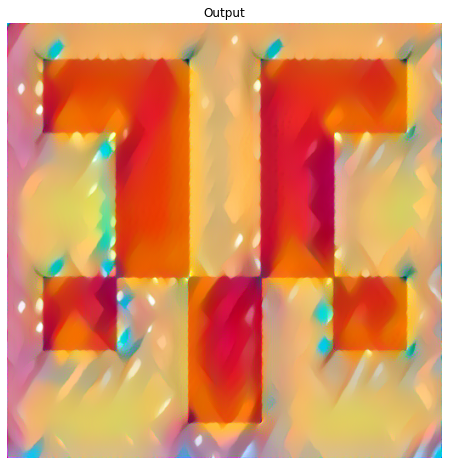

In [20]:
show_image(output.cpu().clone().squeeze(0), title="Output", figsize=(8, 8))